In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [20]:
# Step 2: Load the Dataset
data = pd.read_csv("/Users/supak/Desktop/DDoS 2018/02-15-2018.csv")
print(data.head())
# Randomly sample 1/10 of the data
data = data.sample(frac=1, random_state=42)  # frac=0.1 means 10%, random_state ensures reproducibility
# Preview the sampled data
print(data.head())

   Dst Port  Protocol            Timestamp  Flow Duration  Tot Fwd Pkts  \
0         0         0  15/02/2018 08:25:18      112641158             3   
1        22         6  15/02/2018 08:29:05       37366762            14   
2     47514         6  15/02/2018 08:29:42            543             2   
3         0         0  15/02/2018 08:28:07      112640703             3   
4         0         0  15/02/2018 08:30:56      112640874             3   

   Tot Bwd Pkts  TotLen Fwd Pkts  TotLen Bwd Pkts  Fwd Pkt Len Max  \
0             0                0                0                0   
1            12             2168             2993              712   
2             0               64                0               64   
3             0                0                0                0   
4             0                0                0                0   

   Fwd Pkt Len Min  ...  Fwd Seg Size Min  Active Mean     Active Std  \
0                0  ...                 0          0.0 

In [21]:
# Step 3: Preprocess the Data
data.columns = data.columns.str.strip()
data = data.dropna()
# Encode the target column ('Label')
encoder = LabelEncoder()
data['Label'] = encoder.fit_transform(data['Label'])
# Select only numeric columns for scaling
numeric_columns = data.select_dtypes(include=[np.number]).columns.tolist()
numeric_columns.remove('Label')  # Exclude the target column
# Check for infinite or extremely large values
data[numeric_columns] = data[numeric_columns].replace([np.inf, -np.inf], np.nan)
data = data.dropna(subset=numeric_columns)
# Scale the numeric feature columns
scaler = StandardScaler()
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])
X = data[numeric_columns]
y = data['Label']

In [22]:
# Step 4: Split the Dataset
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [23]:
# Step 5: Initialize Random Forest (can add more parameters)
rf_model = RandomForestClassifier(
    n_estimators=100,            # Number of trees
    max_depth=10,                # Limit the depth of each tree
    min_samples_split=5,         # Minimum samples for a split
    min_samples_leaf=3,          # Minimum samples at a leaf
    max_features='sqrt',         # Use sqrt(n_features) features for splits
    bootstrap=True,              # Use bootstrap sampling
    class_weight='balanced',     # Handle class imbalance
    random_state=42              # Reproducibility
)


In [24]:
# Step 6: Train the Model
rf_model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=3, min_samples_split=5,
                       random_state=42)

In [25]:
# Step 7: Validate the Model
y_val_pred = rf_model.predict(X_val)
print("Validation Results")
print(classification_report(y_val, y_val_pred))

Validation Results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    148185
           1       1.00      1.00      1.00      6262
           2       1.00      1.00      1.00      1635

    accuracy                           1.00    156082
   macro avg       1.00      1.00      1.00    156082
weighted avg       1.00      1.00      1.00    156082



In [26]:
# Step 8: Hyperparameter Tuning
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10]
# }
# grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='accuracy')
# grid_search.fit(X_train, y_train)
# print("Best Parameters:", grid_search.best_params_)

In [27]:
# Step 9: Test the Model
y_test_pred = rf_model.predict(X_test)
print("Test Results")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))
print("Accuracy:", accuracy_score(y_test, y_test_pred))

Test Results
[[148074      1      1]
 [     0   6345      0]
 [     0      0   1662]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    148076
           1       1.00      1.00      1.00      6345
           2       1.00      1.00      1.00      1662

    accuracy                           1.00    156083
   macro avg       1.00      1.00      1.00    156083
weighted avg       1.00      1.00      1.00    156083

Accuracy: 0.9999871863047225


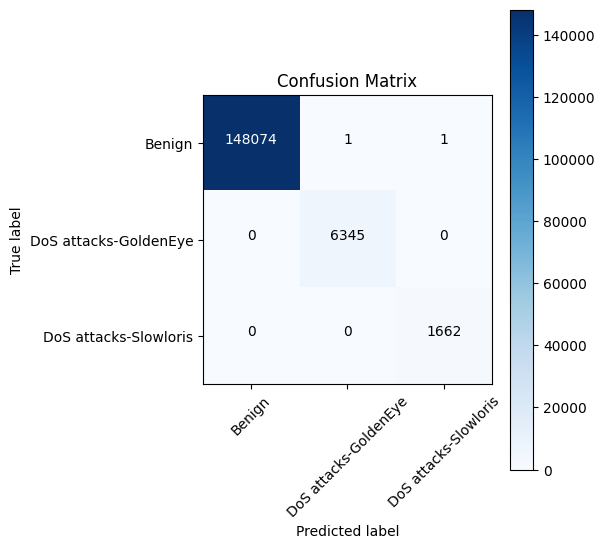

In [28]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV

# Step 10: Confusion Matrix Visualization
def plot_confusion_matrix(cm, classes, title="Confusion Matrix"):
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = "d"
    thresh = cm.max() / 2.0
    for i, j in np.ndindex(cm.shape):
        plt.text(
            j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black"
        )
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()

# Confusion Matrix Plot
cm = confusion_matrix(y_test, y_test_pred)
class_names = encoder.inverse_transform(np.unique(y_test))
plot_confusion_matrix(cm, class_names)

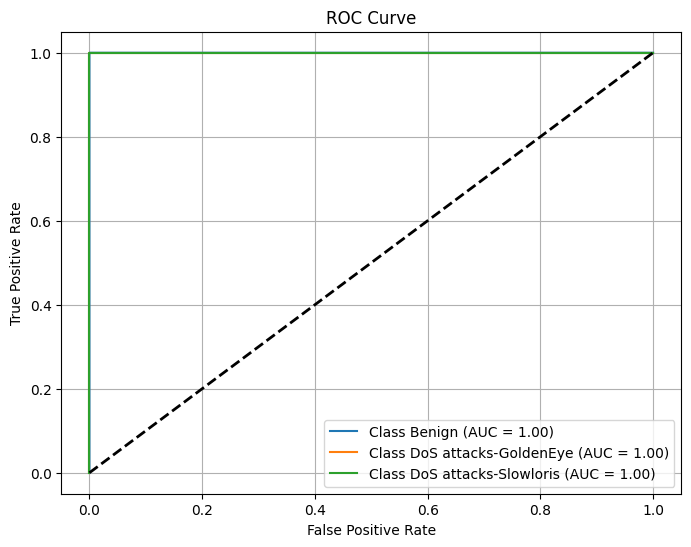

In [29]:
# Step 11: ROC Curve Visualization
y_test_prob = rf_model.predict_proba(X_test)
plt.figure(figsize=(8, 6))
for i in range(y_test_prob.shape[1]):
    fpr, tpr, _ = roc_curve(y_test == i, y_test_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {class_names[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="best")
plt.grid()
plt.show()